In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

ImportError: DLL load failed while importing _cext: The specified module could not be found.

In [8]:
data=pd.read_csv("aps_failure_training_set.csv")
data

FileNotFoundError: [Errno 2] No such file or directory: 'aps_failure_training_set.csv'

# Exploratory Data Analysis

In [36]:
data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [3]:
counts = data['class'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(counts.index, counts.values, color=['blue', 'red'])

for bar, count in zip(bars, counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, count,
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Classes count')
plt.show()

NameError: name 'data' is not defined

Based on this , we can observe that there are many more data points classified as 'neg', which corresponds to air systems without defects, than data points classified as 'pos', which are anamolous air systems.

In [39]:
missing_counts=data.apply(lambda x:x[x=='na'].count())

total_counts=len(data)

misssing_percentage=(missing_counts/total_counts)*100

missing_data=pd.DataFrame({'Columns':missing_counts.index,
                           'Missing Values':missing_counts.values,
                           'Percentage of Missing Values':misssing_percentage.values
                           })

missing_data = missing_data[missing_data['Missing Values'] > 0]
missing_data = missing_data.sort_values(by='Percentage of Missing Values', ascending=False)

print(missing_data)

    Columns  Missing Values  Percentage of Missing Values
79   br_000           49264                     82.106667
78   bq_000           48722                     81.203333
77   bp_000           47740                     79.566667
76   bo_000           46333                     77.221667
113  cr_000           46329                     77.215000
..      ...             ...                           ...
85   by_000             473                      0.788333
97   ck_000             338                      0.563333
96   cj_000             338                      0.563333
95   ci_000             338                      0.563333
81   bt_000             167                      0.278333

[169 rows x 3 columns]


In [42]:
# Get columns with more than 50% missing values

coloumns_with_missing_values=missing_data[missing_data['Percentage of Missing Values']>50]['Columns'].tolist()

print(coloumns_with_missing_values)

['br_000', 'bq_000', 'bp_000', 'bo_000', 'cr_000', 'ab_000', 'bn_000', 'bm_000']


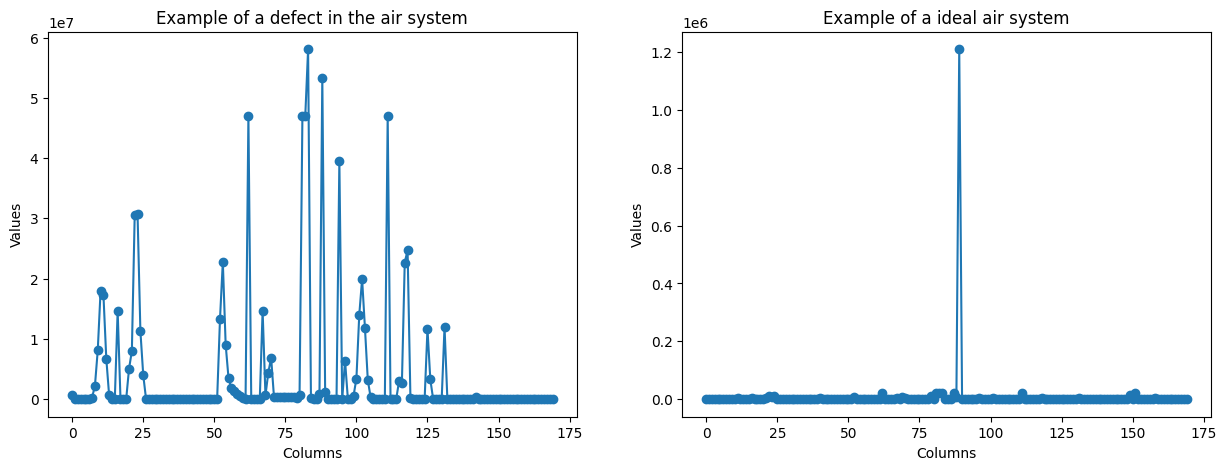

In [47]:
def plot_examples(index):
    data_copy=data.copy()
    data_copy.replace('na',0,inplace=True)
    
    positive=data_copy[data_copy['class']=='pos'].iloc[index].drop('class',axis=0)
    negative=data_copy[data_copy['class']=='neg'].iloc[index].drop('class',axis=0)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(positive.values,marker='o',linestyle='-')
    plt.xlabel('Columns')
    plt.ylabel('Values')
    plt.title('Example of a defect in the air system')
    
    plt.subplot(1,2,2)
    plt.plot(negative.values,marker='o',linestyle='-')
    plt.xlabel('Columns')
    plt.ylabel('Values')
    plt.title('Example of a ideal air system')
    
    plt.show()

plot_examples(3)    

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [20]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())


Let’s learn to deal with class-imbalance this time! We will consider the IDA2016 Challenge dataset for 
our experimentation.    The dataset is a binary classification y = {‘pos’, ‘neg’} problem with 170 
features and 60,000 data points.    The craziness here is that the class ratio is 1:59, that is, for every 
positive data point, there are 59 negative data points in the training data.    The challenge dataset has 
a training file (aps_failure_training_set.csv) and a testing file (aps_failure_test_set.csv).    We will 
consider only the training file for our experimentation.

# Task 1
* Split the data file (aps_failure_training_set.csv) into train and test partitions. 
* Build baseline classifiers {SVC, LogReg and DecisionTree} by cross-validating the best hyper-parameters of the respective models. For SVC, the hyperparametes are {kernel, kernel-params}; for LogReg 
{regularization choice L1/L2, regularization params}; and for DT {depth, leaf size}. 
Upon using GridSearchCV, the best parameters are to be found.
* Note that, GridSearchCV does 5-fold CV by default, which is sufficient for us.  Once the parameters are fixed, you will learn the models on the train partition and report the performance metrics on the train and test partitions.

In [21]:

X=data.drop(['class'], axis=1)
y=data['class'].apply(lambda x: 1 if x == 'pos' else 0)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=355)

In [22]:
X_train

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
32318,24,na,64,32,0,0,0,0,0,0,...,470,110,46,20,20,6,0,0,0,0
879,4240,0,44,38,0,0,0,0,0,0,...,9658,2854,6162,7172,13680,131922,626,0,0,0
35059,1646,na,34,30,0,0,0,0,0,0,...,7478,3138,25132,40036,514,16,0,0,0,0
57467,688922,na,5606,na,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,41240,na,0,na,0,0,0,0,0,0,...,397886,202418,425808,330576,225418,117970,160142,15506,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26675,7524,na,0,na,0,0,0,0,0,0,...,66450,34342,59776,68808,27534,19006,50162,7084,0,0
7459,61438,na,2130706434,380,0,0,0,0,0,0,...,730592,355826,674776,551082,352684,132990,45990,0,0,0
24053,14,0,22,20,0,0,0,0,0,0,...,78,18,78,88,42,10,0,0,0,0
19074,310458,na,na,na,na,na,0,0,9054,864026,...,1418056,582420,1048676,1004720,4207426,4725768,34778,0,na,na


In [41]:



scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


classifiers = {
    'SVC': SVC(),
    'LogisticRegression': LogisticRegression(solver='liblinear'),
    'DecisionTree': DecisionTreeClassifier()
}

param_grids = {
    'SVC': {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10]
    },
    'DecisionTree': {
        'max_depth': [10, 20, 30],
        'min_samples_leaf': [1, 2, 4]
    }
}

for model_name, model in classifiers.items():
    print(f"\nTraining {model_name}...")

    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

    print(f"{model_name} - Training Performance:")
    y_train_pred = grid_search.predict(X_train)
    print(classification_report(y_train, y_train_pred))

    print(f"{model_name} - Test Performance:")
    y_test_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_test_pred))


ValueError: could not convert string to float: 'na'

Baseline Model Classifier
1. SVC

2. LogReg

3. Decision Tree

# Task 3
Now, we want to address the class imbalance via multiple approaches. You are expected to apply the 
following in all the three families of classifiers. 
a) Consider undersampling the majority class and/or oversampling the minority class. 
b) Consider using class_weight which is inversely proportional to the class population. 
c) Consider using sample_weights, where you may assign a penalty for misclassifying every data 
point depending on the class it falls in. 
d) Consider any other creative ideas to address the class imbalance. 
The goal here is the classification performance metric (macro average F_1) of the hacked classifiers 
should be better than the baseline classifiers. 